# Школа глубокого обучения ФПМИ МФТИ. Сегментация изображений

## Формализованное ТЗ

Для собственного удобства сделаем себе список задач
- загрузить датасет, визуализировать изображения, разбить сет на выборки: обучающую, валидационную, тестовую
- реализовать архитектуры сверточных сетей для сегментации на базе Segnet и Unet (не обязательно дублировать из статей)
- реализовать функции потерь: BCE, Dice, Focal, другие на выбор
- обучить все построенные модели, используя все реализованные функции потерь
- измерить метриики, построить обучающие кривые
- сделать вывод о лучшей архитектуре и функции потерь для текущей задачи
- написать отчет о работе

Плановый срок выполнения - 14 дней

Форма отчета - настоящий ноутбук

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>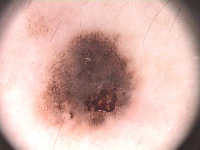</td><td>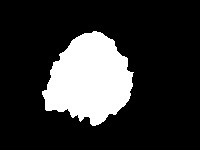</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

## Подготовка данных

In [1]:
pretrain_cycle = 20
full_epoch_cycle = 150
factor = 0.2

from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings('ignore')
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import Dataset, DataLoader
import copy
import gc
import pandas as pd
from random import randrange
import time
import os.path
if not os.path.exists('PH2Dataset.rar'):
    try:
        !wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
    except:
        !curl.exe https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
else: 
    print('already downloaded')

already downloaded


In [2]:
result = pd.DataFrame()
complete_history = {}

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [4]:
images = []
lesions = []
images_paths = []
lesions_paths = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
        images_paths.append(os.path.join(root, files[0]))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))
        lesions_paths.append(os.path.join(root, files[0]))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей.

In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
X_mean = X.mean(axis=(0,1,2), keepdims=True)
X_std = X.std(axis=(0,1,2), keepdims=True)
X_plot = X
X = (X - X_mean) / X_std

In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

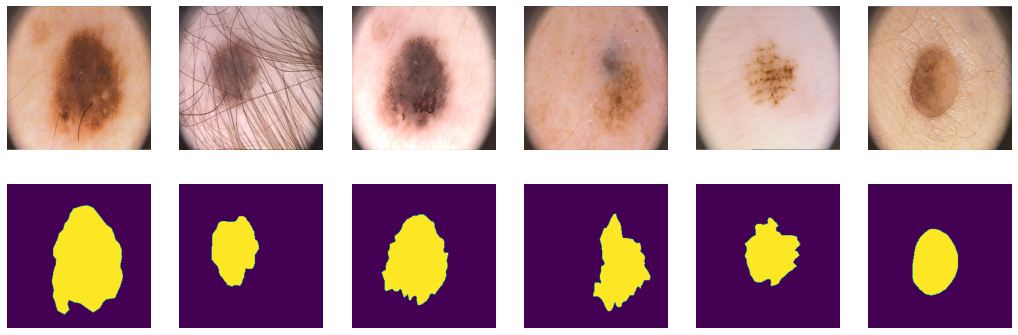

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X_plot[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [10]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader и аугментация

Главное - чтобы батч влезал в память видеокарты дома.

В аугментациях оставлены закомментированные строки, чтобы потом можно было поиграть.

В целом я пришел к выводу, что сильные аугментации в этой задаче делают обучение очень нестабильным.

In [12]:
train_transform = A.Compose(
    [
        #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.25, rotate_limit=360, p=0.5),
        #A.Transpose(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        #A.OpticalDistortion(),
        #A.Rotate(45),
        #A.Resize(height=int(256*1.05), width=int(256*1.05)),
        #A.RandomResizedCrop(height=256, width=256),
        #A.SafeRotate(45),
        A.Resize(height=256, width=256),
        A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

Сделаем датасет, который будет заново загружать картинки из файлов.

In [13]:
class SkinDataset(Dataset):
    def __init__(self, images_filepaths, masks_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.masks_filepaths = masks_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask_filepaths = self.masks_filepaths[idx]
        mask = cv2.imread(mask_filepaths, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            transformed = self.transform(image=image, masks=[mask])
            image = transformed['image']
            mask = transformed['masks'][0]
        return image, (np.expand_dims(mask, axis=0) / 255)

Посмотрим на аугментированные изображения.

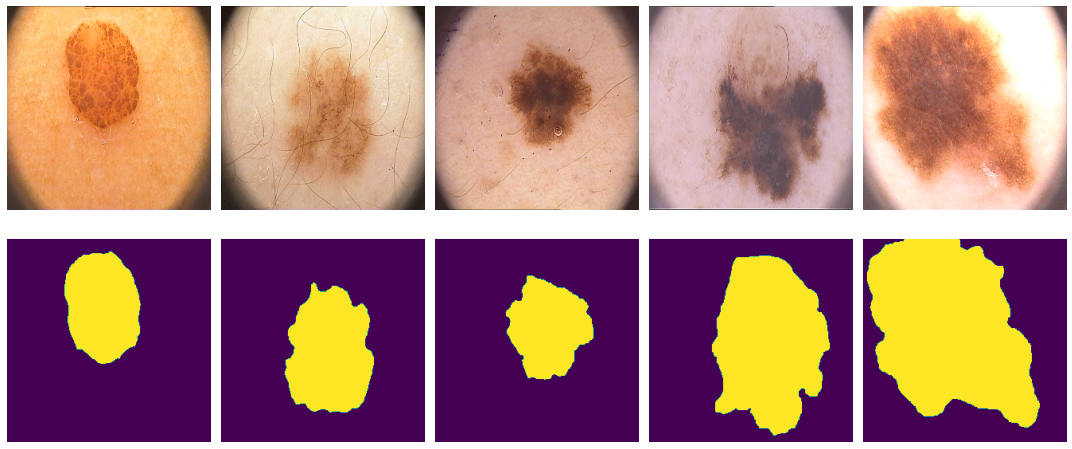

In [14]:
num_images = 5
tmp = SkinDataset(images_paths, lesions_paths, train_transform)
tmp.transform = A.Compose([t for t in tmp.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
fig = plt.figure(figsize=(15,7))
for i in range(num_images):
    j = randrange(len(tmp))
    image, mask = tmp[j]
    plt.subplot(2, num_images, 1+i)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(2, num_images, 1+i+num_images)
    plt.imshow(np.squeeze(mask,0))
    plt.axis('off')
fig.patch.set_facecolor('xkcd:white')
fig.tight_layout()
plt.show()

Создаем даталоадеры.

In [15]:
from torch.utils.data import DataLoader
batch_size = 8

data_tr = DataLoader(SkinDataset([images_paths[i] for i in tr], 
                                 [lesions_paths[i] for i in tr], 
                                 train_transform), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(SkinDataset([images_paths[i] for i in val], 
                                  [lesions_paths[i] for i in val], 
                                  test_transform), 
                      batch_size=batch_size, shuffle=True) # shuffle нам не помешает, это прописано в трейне
data_ts = DataLoader(SkinDataset([images_paths[i] for i in ts], 
                                 [lesions_paths[i] for i in ts], 
                                 test_transform), 
                     batch_size=batch_size, shuffle=False)

Проверяем размерности.

In [16]:
for i in data_tr:
    print(i[0].shape)
    print(i[1][1].min())
    break

torch.Size([8, 3, 256, 256])
tensor(0., dtype=torch.float64)


Готовим GPU.

In [17]:
import torch
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()

# Реализация различных архитектур

# SegNet

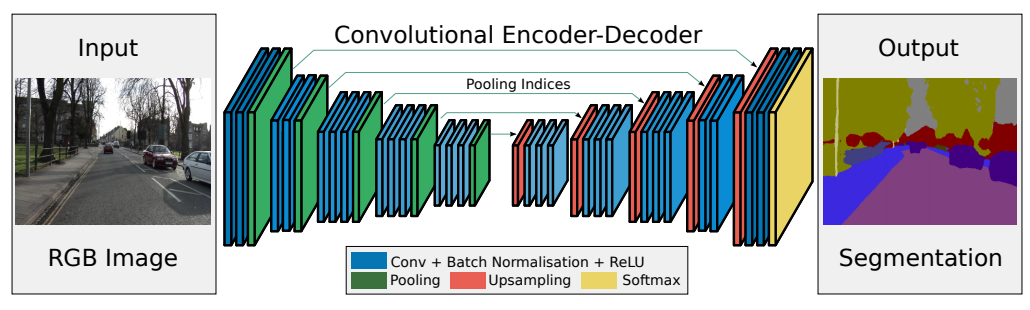

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Энкодер сегнета построен на vgg16 (см. статью). Поэтому не будем писать с нуля велосипед, а воспользуемся готовой предобученной сетью. Единственная проблема - нам надо после каждого пулинга сохранять индексы, поэтому разобъем сеть на вот такие блоки.

In [20]:
vgg16_bn = models.vgg16_bn(pretrained=True)
test_model = nn.Sequential(*list(vgg16_bn.features.children())[0:6])
test_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)

Теперь свертки декодера. Тоже будем делать их блоками.

In [21]:
def create_conv_seq(in_channels=512, out_channels=256, conv_layers=2, drop=0.2):
    conv_params = dict(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    momentum = 0.1
    res = torch.nn.Sequential()
    for i in range(conv_layers-1):
        res.add_module('conv' + str(i+1), nn.Conv2d(in_channels, in_channels, **conv_params))
        res.add_module('bn' + str(i+1), nn.BatchNorm2d(in_channels, momentum=momentum))
        res.add_module('relu' + str(i+1), nn.ReLU(inplace=True))
        res.add_module('drop' + str(i+1), nn.Dropout2d(drop))
    res.add_module('conv' + str(conv_layers), nn.Conv2d(in_channels, out_channels, **conv_params))
    res.add_module('bn' + str(conv_layers), nn.BatchNorm2d(out_channels, momentum=momentum))
    res.add_module('relu' + str(conv_layers), nn.ReLU(inplace=True))
    res.add_module('drop' + str(conv_layers), nn.Dropout2d(drop))
    return res

Тест размерности.

In [22]:
a = create_conv_seq()
x_test = torch.randn((8,512,16,16))
a(x_test).shape

torch.Size([8, 256, 16, 16])

In [23]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16_bn = models.vgg16_bn(pretrained=True)
        pool_params = dict(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
        self.unpool_params = dict(kernel_size=2, stride=2)

        # encoder
        self.enc_conv0 = nn.Sequential(*list(vgg16_bn.features.children())[0:6]) # 256 px, 64 ch
        self.pool0 = nn.MaxPool2d(**pool_params) # 128 px, 64 ch
        self.enc_conv1 = nn.Sequential(*list(vgg16_bn.features.children())[7:13]) # 128 px, 128 ch
        self.pool1 = nn.MaxPool2d(**pool_params) # 64 px, 128 ch
        self.enc_conv2 = nn.Sequential(*list(vgg16_bn.features.children())[14:23]) # 64 px, 256 ch
        self.pool2 = nn.MaxPool2d(**pool_params) # 32 px, 256 ch
        self.enc_conv3 = nn.Sequential(*list(vgg16_bn.features.children())[24:33]) # 32 px, 512 ch
        self.pool3 = nn.MaxPool2d(**pool_params) # 16 px, 512 ch
        self.enc_conv4 = nn.Sequential(*list(vgg16_bn.features.children())[34:43]) # 16 px, 512 ch
        self.pool4 = nn.MaxPool2d(**pool_params) # 8 px, 512 ch

        # decoder
        self.dec_conv4 = create_conv_seq(512, 512, 3)
        self.dec_conv3 = create_conv_seq(512, 256, 3)
        self.dec_conv2 = create_conv_seq(256, 128, 3)
        self.dec_conv1 = create_conv_seq(128, 64, 3)
        self.dec_conv0 = create_conv_seq(64, 1, 3)

    def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))
        e4, idx4 = self.pool0(self.enc_conv4(e3))

        # decoder
        d4 = self.dec_conv4(F.max_unpool2d(e4, idx4, **self.unpool_params))
        d3 = self.dec_conv3(F.max_unpool2d(d4, idx3, **self.unpool_params))
        d2 = self.dec_conv2(F.max_unpool2d(d3, idx2, **self.unpool_params))
        d1 = self.dec_conv1(F.max_unpool2d(d2, idx1, **self.unpool_params))
        d0 = self.dec_conv0(F.max_unpool2d(d1, idx0, **self.unpool_params))
        #return torch.sigmoid(d0)
        return d0

Проверим, что оно срабатывает.

In [24]:
model = SegNet()
x_test = torch.randn((4,3,256,256))
model(x_test).shape

torch.Size([4, 1, 256, 256])

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Имплементируем метрику на торче в ее классическом варианте.

In [25]:
def iou_numpy(outputs: np.array, labels: np.array, threshold=0.5):
    SMOOTH = 1e-9
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)
    outputs = (outputs > threshold) + 0
    intersection = (outputs * labels).sum((1, 2))
    sum_ = (outputs + labels).sum((1, 2))
    iou = (intersection + SMOOTH) / (sum_ - intersection + SMOOTH * 100)
    return iou

Проверка.

In [26]:
outputs = np.array([[[
    [0.4, 0.7, 0.1],
    [0.1, 0.6, 0.1],
    [0.1, 0.9, 0.4]
]],
[[
    [0.9, 0.7, 0.1],
    [0.1, 0.6, 0.1],
    [0.1, 0.9, 0.1]
]
]])
labels = np.array([[[
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
]],
[[
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
]
]])
iou_numpy(outputs, labels)

array([0.74999998, 0.99999998])

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Готовые реализации в торче:
- [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)
- [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html?highlight=bceloss#torch.nn.BCELoss)

Оказывается, для стабильности в торче используется искусственное ограничение логарифмов в диапазоне от -100 до +100

In [27]:
def bce_loss(y_pred, y_real):
    log_pred = torch.clamp(torch.log(torch.sigmoid(y_pred)), -100, 100)
    log_pred_rev = torch.clamp(torch.log(1 - torch.sigmoid(y_pred)), -100, 100)
    return - (
        y_real * log_pred + (1 - y_real) * log_pred_rev
    ).mean()

def bce_loss_stable(y_pred, y_real):
    # return (y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))).mean()
    return (y_pred * (1 - y_real) + torch.log(1 + torch.exp(-y_pred))).mean()

Проверим, что функции работают верно

In [28]:
y_t = torch.randint(0, 1, (8,1,256,256))
y_p = torch.randn((8,1,256,256))
print('Handmade BCE loss:', bce_loss(y_p, y_t))
print('Handmade BCE loss (stable):', bce_loss_stable(y_p, y_t))
l = torch.nn.BCELoss()
print('Pytorch BCE loss:', l(torch.sigmoid(y_p), y_t.to(torch.float32)))

Handmade BCE loss: tensor(0.8062)
Handmade BCE loss (stable): tensor(0.8062)
Pytorch BCE loss: tensor(0.8062)


## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [29]:
def predict(model, data):
    model.eval()  # testing mode
    X_images = []
    Y_preds = []
    Y_labels = []
    with torch.no_grad():
        for X_batch, Y_batch in data:
            X_images.append(X_batch.cpu().detach().numpy())
            Y_labels.append(Y_batch.cpu().detach().numpy())
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            Y_preds.append(torch.sigmoid(Y_pred).cpu().detach().numpy())

    Y_preds = np.vstack(Y_preds)
    X_images = np.vstack(X_images)
    Y_labels = np.vstack(Y_labels)
    
    return X_images, Y_labels, Y_preds

Проверка

In [30]:
model.to(device)
a = predict(model, data_val)
a[0].shape, a[1].shape, a[2].shape

((50, 3, 256, 256), (50, 1, 256, 256), (50, 1, 256, 256))

In [31]:
def score_model(model, metric, data):
    _, Y_labels, Y_preds = predict(model, data)
    return metric(Y_preds, Y_labels).mean()

Проверка

In [32]:
score_model(model, iou_numpy, data_val)
model.cpu();

Функция для счета параметров модели.

In [33]:
def count_model_params(model):
    n = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f'{n:.1e}'
count_model_params(model)

'3.0e+07'

Функция для общей проверки модели и формирования результата в виде строки таблицы.

In [34]:
def get_all_scores(model, name='noname', result=None):
    tic = time.time()
    train_metr = score_model(model, iou_numpy, data_tr)
    val_metr = score_model(model, iou_numpy, data_val)
    test_metr = score_model(model, iou_numpy, data_ts)
    res = dict(
        name=name,
        train_metr=train_metr,
        val_metr=val_metr,
        test_metr=test_metr,
        #inference_time=round(time.time() - tic, 2),
        params=count_model_params(model)
    )
    if type(result) == type(None):
        return res
    else:
        result = result.append(res, ignore_index=True).drop_duplicates()
        display(result)
        return result

## Тренировка

Определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [35]:
def plot_train_curves(history, name=''):
    train_loss, val_loss, train_metr, val_metr, lr = history['train_loss'], history['val_loss'], history['train_metr'], history['val_metr'], history['lr'], 
    fig = plt.figure(figsize=(6,8))
    fig.patch.set_facecolor('xkcd:white')
    plt.subplot(3,1,1)
    points = np.array(train_loss + val_loss, dtype=float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend()
    plt.ylim(lim1, lim2)
    plt.xlabel("epochs")
    plt.ylabel("loss")

    plt.subplot(3,1,2)
    plt.plot(train_metr, label="train_metr")
    plt.plot(val_metr, label="val_metr")
    my = np.array(val_metr).max()
    mx = np.argmax(np.array(val_metr))
    plt.scatter(x=[mx], y=[my], c='red', s=80)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("metric")

    plt.subplot(3,1,3)
    plt.plot(lr, label="LR")
    plt.xlabel("epochs")
    plt.ylabel("LR")
    plt.yscale('log')
    
    if len(name) > 0:
        plt.suptitle(name)
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.savefig(name+'.png')
    plt.show()

Напишем большую функцию тренировки, которая будет делать все, что нам надо.

In [36]:
def train(model, optimizer, loss_fn, epochs, data_tr, data_val, metric, 
          scheduler=None, plots=True, set_best_params=True, name=''):
    X_val, Y_val = next(iter(data_val))
    
    best_metr = None
    best_epoch = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = dict(
        train_loss = [],
        val_loss = [],
        train_metr = [],
        val_metr = [],
        lr = []
    )

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}, best = {best_epoch}')

        history['lr'].append(optimizer.param_groups[0]["lr"])

        avg_loss = 0
        model.train()  # train mode
        Y_preds = [] # probabilities [0..1]
        Y_labels = [] # GT 0 or 1
        losses = []
        for i, (X_batch, Y_batch) in enumerate(data_tr):
            Y_labels.append(Y_batch.cpu().detach().numpy()) # save GT
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            optimizer.zero_grad()

            # forward
            Y_rough = model(X_batch) # get rough output (-inf..inf)
            Y_preds.append(torch.sigmoid(Y_rough).cpu().detach().numpy()) # append prob [0..1]
            loss = loss_fn(Y_rough, Y_batch) # loss based on rough
            loss.backward()
            losses.append(loss.cpu().detach().item())
            optimizer.step()

        Y_preds = np.vstack(Y_preds)
        Y_labels = np.vstack(Y_labels)
        epoch_loss = np.array(losses).mean()
        history['train_metr'].append(metric(Y_preds, Y_labels).mean())
        history['train_loss'].append(epoch_loss)

        model.eval()  # testing mode
        X_images = []
        Y_preds = []
        Y_labels = []
        losses = []
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                X_images.append(X_batch.cpu().detach().numpy())
                Y_labels.append(Y_batch.cpu().detach().numpy())
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                Y_pred = model(X_batch)
                Y_preds.append(torch.sigmoid(Y_pred).cpu().detach().numpy())
                loss = loss_fn(Y_pred, Y_batch)
                losses.append(loss.cpu().detach().item())

        Y_preds = np.vstack(Y_preds)
        X_images = np.vstack(X_images)
        Y_labels = np.vstack(Y_labels)
        epoch_loss = np.array(losses).mean()
        history['val_metr'].append(metric(Y_preds, Y_labels).mean())
        history['val_loss'].append(epoch_loss)
        
        if best_metr == None: best_metr = history['val_metr'][-1]
        if history['val_metr'][-1] > best_metr:
            print('new best val metric!')
            best_epoch = epoch + 1
            best_metr = history['val_metr'][-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            # torch.save(model, 'H:/Google_d/2022_DL_Stepik/Home_05_Simpsons/model' + f'{val_f1:.4}' + '.pt')

        if scheduler != None: scheduler.step(history['val_loss'][-1])

        # Visualize tools
        clear_output(wait=True)
        if plots:
            fig = plt.figure(figsize=(10,5.5))
            for k in range(6):
                plt.subplot(3, 6, k+1)
                x_plot = X_images[k]
                x_plot = (x_plot - x_plot.min()) / (x_plot.max() - x_plot.min())
                plt.imshow(np.rollaxis(x_plot, 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(3, 6, k+1+6)
                plt.imshow(Y_labels[k, 0], cmap='Greens')
                plt.imshow(Y_preds[k, 0] > 0.5, cmap='Reds', alpha=0.4)
                plt.title('GT vs output')
                plt.axis('off')

                plt.subplot(3, 6, k+1+6*2)
                plt.imshow(Y_preds[k, 0], cmap='Reds')
                plt.title('Probability')
                plt.axis('off')

                train_m = history['train_metr'][-1]
                val_m = history['val_metr'][-1]

            plt.suptitle(
                f'{name}   Epoch: {epoch+1}/{epochs}   train metric: {train_m:.4f}   valid metric: {val_m:.4f}   [best metric {best_metr:.4f}]'
                        )
            fig.patch.set_facecolor('xkcd:white')
            fig.tight_layout()
            plt.show()

            if epoch > 1:
                plot_train_curves(history, name)
    
    if set_best_params:
        model.load_state_dict(best_model_wts)
        print(f'Weights loaded from best epoch {best_epoch}, metric = {best_metr:0.4f}')
            
    return(history)

## Обучение

In [37]:
clear_GPU()
model = SegNet().to(device)
name = 'SegNet+BCE loss'

Segnet идет с предобученным энкодером от VGG, поэтому для начала обучим только декодер.

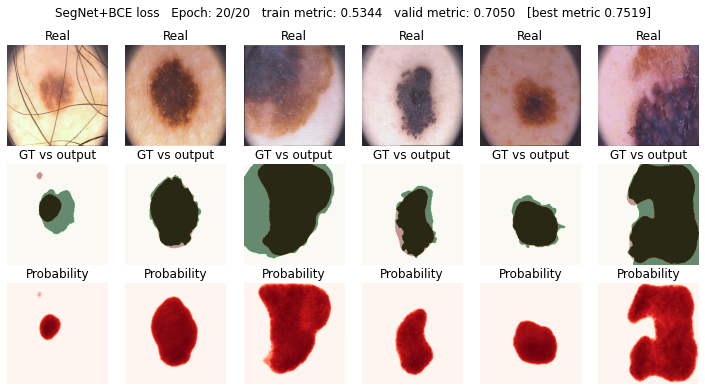

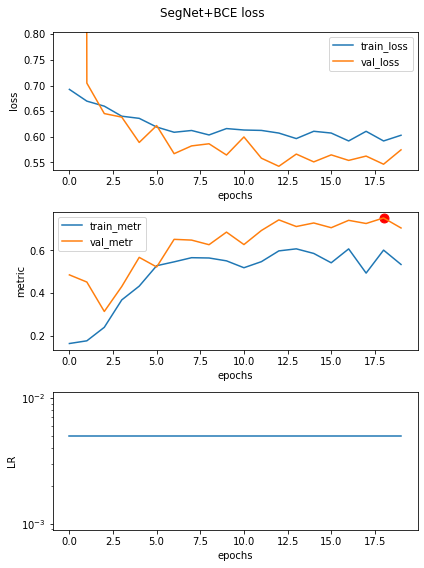

Weights loaded from best epoch 19, metric = 0.7519


In [38]:
loss = bce_loss_stable
max_epochs = pretrain_cycle
base_lr = 5e-3
optim = torch.optim.AdamW([
    dict(params=model.dec_conv0.parameters()),
    dict(params=model.dec_conv1.parameters()),
    dict(params=model.dec_conv2.parameters()),
    dict(params=model.dec_conv3.parameters()),
    dict(params=model.dec_conv4.parameters()),
], lr=base_lr, weight_decay=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

А теперь размораживаем энкодер и ставим скорость обучения поменьше.

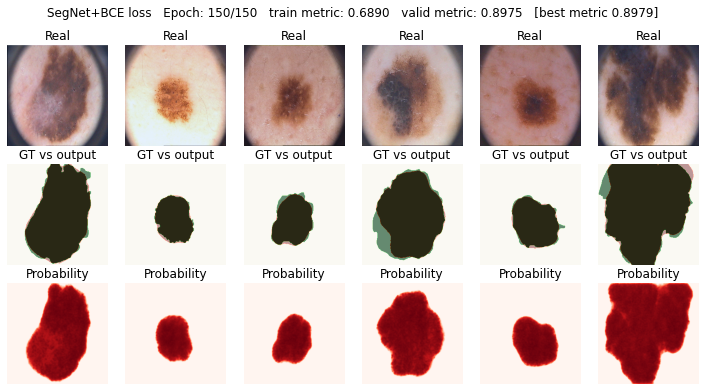

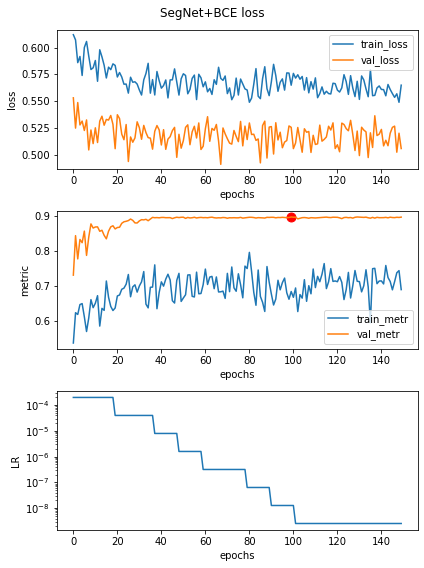

Weights loaded from best epoch 100, metric = 0.8979


In [39]:
max_epochs = full_epoch_cycle
base_lr = 2e-4 # 2e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, bce_loss_stable, max_epochs, 
                               data_tr, data_val, iou_numpy, scheduler, name=name);

In [40]:
result = get_all_scores(model, name, result)

name  train_metr  val_metr  test_metr   params
0  SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07

## Дополнительные функции потерь

### Dice coefficient

Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудем о численной нестабильности, возникающей в математической формуле.

Так как нам лосс нужен исключительно для бэкпропа, оставим в формуле только основную дифференцируемую часть.

In [41]:
def dice_loss(y_pred, y_real):
    preds = torch.sigmoid(y_pred)
    smooth = 1e-8
    dims = (1, 2, 3)
    intersection = torch.sum(preds * y_real, dims)
    cardinality = torch.sum(preds + y_real, dims)
    # Ниже приведен "правильный" код, но он не нужен для обучения и ухудшает читаемость графиков
    # return (1 - (2 * intersection + smooth) / (cardinality + smooth) / 256 / 256).mean()
    return - ((intersection + smooth) / (cardinality + smooth)).mean()

In [42]:
y_t = torch.randint(0, 2, (8,1,256,256))
y_p = torch.randn((8,1,256,256))
print('Handmade Dice loss:', dice_loss(y_p, y_t))

Handmade Dice loss: tensor(-0.2499)


Проводим тестирование:

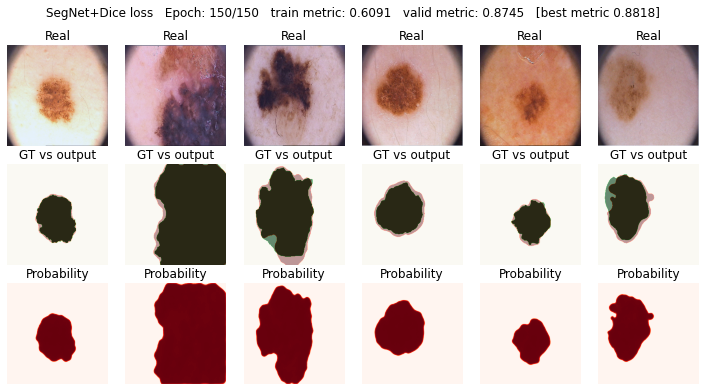

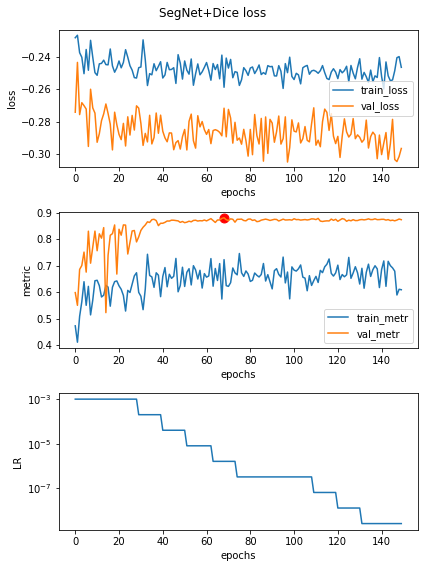

Weights loaded from best epoch 69, metric = 0.8818


name  train_metr  val_metr  test_metr   params
0   SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1  SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07

In [43]:
clear_GPU()
model = SegNet().to(device)
loss = dice_loss
name = 'SegNet+Dice loss'

max_epochs = pretrain_cycle
base_lr = 1e-2
optim = torch.optim.AdamW([
    dict(params=model.dec_conv0.parameters()),
    dict(params=model.dec_conv1.parameters()),
    dict(params=model.dec_conv2.parameters()),
    dict(params=model.dec_conv3.parameters()),
    dict(params=model.dec_conv4.parameters()),
], lr=base_lr, weight_decay=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

max_epochs = full_epoch_cycle
base_lr = 1e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, 
                               data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

### Focal loss

[Статья про Focal loss](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

[Полностью написанная формула](https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.binary_focal_loss.html#focal_loss.binary_focal_loss)

In [44]:
def focal_loss(y_pred, y_real):#, gamma=2, alpha=0.5):
    gamma = 2
    alpha = 0.25
    eps = 1e-7
    prob = torch.sigmoid(y_pred)
    prob = torch.clamp(prob, eps, 1-eps)
    log_pred = torch.clamp(torch.log(prob), -100, 100)
    log_pred_rev = torch.clamp(torch.log(1 - prob), -100, 100)
    positives = alpha * torch.pow(- prob + 1, gamma) * y_real * log_pred
    negatives = (1 - alpha) * torch.pow(prob, gamma) * (1 - y_real) * log_pred_rev
    loss = - (positives + negatives).mean()
    return loss

y_t = torch.randint(0, 2, (8,1,256,256))
y_p = torch.randn((8,1,256,256), requires_grad=True)
print('Handmade Focal loss:', focal_loss(y_p, y_t))

Handmade Focal loss: tensor(0.1732, grad_fn=<NegBackward0>)


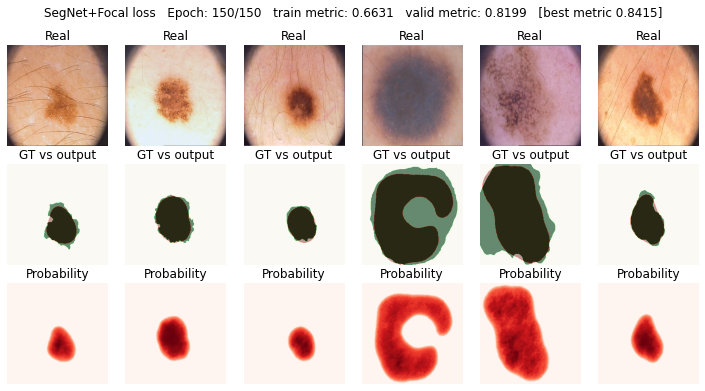

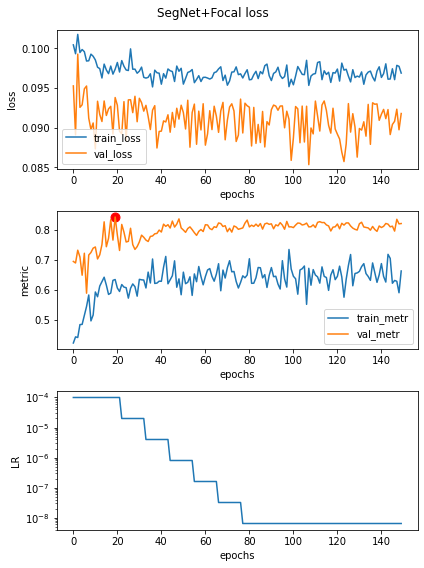

Weights loaded from best epoch 20, metric = 0.8415


name  train_metr  val_metr  test_metr   params
0    SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1   SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2  SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07

In [45]:
clear_GPU()
model = SegNet().to(device)
loss = focal_loss
name = 'SegNet+Focal loss'

max_epochs = pretrain_cycle
base_lr = 2e-3
optim = torch.optim.AdamW([
    dict(params=model.dec_conv0.parameters()),
    dict(params=model.dec_conv1.parameters()),
    dict(params=model.dec_conv2.parameters()),
    dict(params=model.dec_conv3.parameters()),
    dict(params=model.dec_conv4.parameters()),
], lr=base_lr, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

max_epochs = full_epoch_cycle
base_lr = 1e-4
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, 
                               data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

## Мир сегментационных лоссов

Предложенные варианты:
1) Можно учесть Total Variation

2) Lova

3) [BCE но с Soft Targets](https://leimao.github.io/blog/Label-Smoothing/#:~:text=Label%20smoothing%20is%20a%20regularization,during%20training%20and%20generalizing%20poorly.) (что-то типа label-smoothing для многослассовой классификации)

4) Любой другой:

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

### Soft Target BCE

Самая простая и универсальная функция потерь, подходящая для любых задач классификации.

По сути берем BCE loss и с определенным коэффициентом "сглаживаем" целевые метки классов. Коэффициент подбирается вручную. В результате модель получает штрафы за "сверхуверенность" в метках.

В статьях предлагают коэффициент сглаживания 0.1.

In [46]:
# Неправильная (вычислительно затратная) имплементация - показывает логику работы
def soft_target_bce_loss_BAAAAAD(y_pred, y_real):
    eps = 0.1
    return (1 - eps) * bce_loss_stable(y_pred, y_real) + eps * bce_loss_stable(y_pred, 0.5)

# Правильная имплементация
def soft_target_bce_loss(y_pred, y_real):
    eps = 0.1
    return (y_pred * (1 - (y_real * (1 - eps) + 1/2 * eps)) + torch.log(1 + torch.exp(-y_pred))).mean()

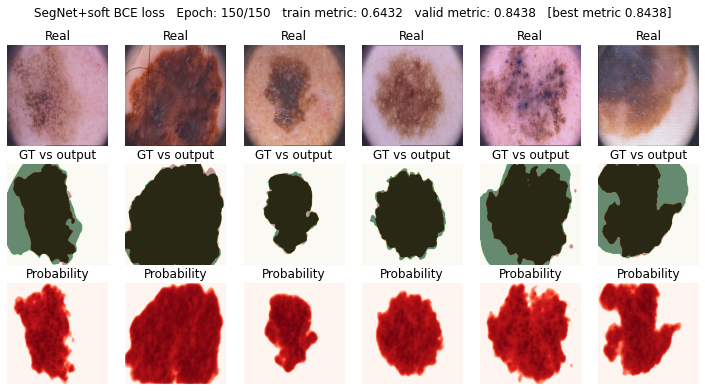

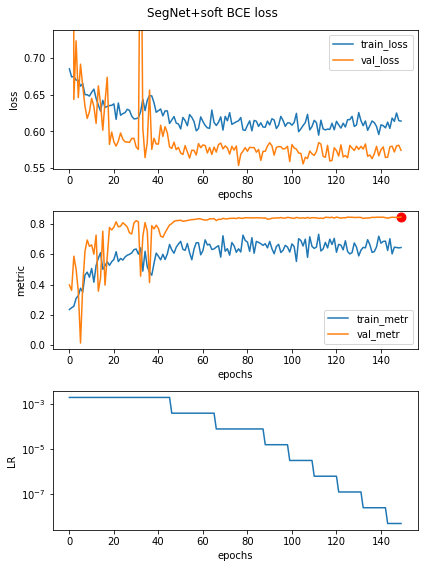

Weights loaded from best epoch 150, metric = 0.8438


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07

In [47]:
clear_GPU()
model = SegNet().to(device)
loss = soft_target_bce_loss
name = 'SegNet+soft BCE loss'

max_epochs = pretrain_cycle
base_lr = 5e-3
optim = torch.optim.AdamW([
    dict(params=model.dec_conv0.parameters()),
    dict(params=model.dec_conv1.parameters()),
    dict(params=model.dec_conv2.parameters()),
    dict(params=model.dec_conv3.parameters()),
    dict(params=model.dec_conv4.parameters()),
], lr=base_lr, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

max_epochs = full_epoch_cycle
base_lr = 2e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, 
                               data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

Очень удобная функция потерь, которая делает обучение более стабильным и плавным.

### Hinge loss

Функция, которая вообще не штрафует за правильные ответы, в которых модель уверена. [Пояснения](https://www.youtube.com/watch?v=PM2MSAYmzXM)

In [48]:
def hinge_loss(y_pred, y_real):
    signs = 2. * y_real.float() - 1.
    return (signs * torch.relu(1 - y_pred)).sum()

In [49]:
y_t = torch.randint(0, 2, (8,1,256,256))
y_p = torch.randn((8,1,256,256))
print('Handmade hinge loss:', hinge_loss(y_p, y_t))

Handmade hinge loss: tensor(-1373.5194)


Я попробовал, и понял, что сама по себе эта функция потерь работает плохо. Возможно, стоит прибавлять ее к BCE.

### Lovasz Hinge

[Пояснения](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/67791)

In [50]:
def lovasz_hinge(y_pred, y_real):
    # делаем тензоры одномерными
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    # делаем из меток 0/1 значения -1/1
    signs = 2. * y_real.float() - 1.
    # вычисляем тензор ошибок
    errors = (1. - y_pred * signs)
    # сотрируем содержимое тензора ошибок
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    # сортируем реальные метки классов - после этого у нас оба массива: предсказания и метки - сортированы одинаково
    gt_sorted = y_real[perm.data]
    p = len(gt_sorted)
    # вычисляем сумму всех истинных лейблов
    gts = gt_sorted.sum()
    # создаем сортированный вектор метрики IOU (также называется Jaccard index),
    # где первым членом идет ПОЛНАЯ ошибка всего батча (для этого cumsum)
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    # Теперь как бы "дифференцируем" этот вектор таким образом, чтобы наиболее выские ошибки сильнее всего исправлялись
    jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    # А теперь аналог Hinge loss, причем штрафуем только те объекты, на которых ошиблись
    loss = torch.dot(F.relu(errors_sorted), jaccard)
    return loss   

In [51]:
y_t = torch.randint(0, 2, (8,1,256,256))
y_p = torch.randn((8,1,256,256))
print('Handmade hinge loss:', lovasz_hinge(y_p, y_t))

Handmade hinge loss: tensor(1.4359)


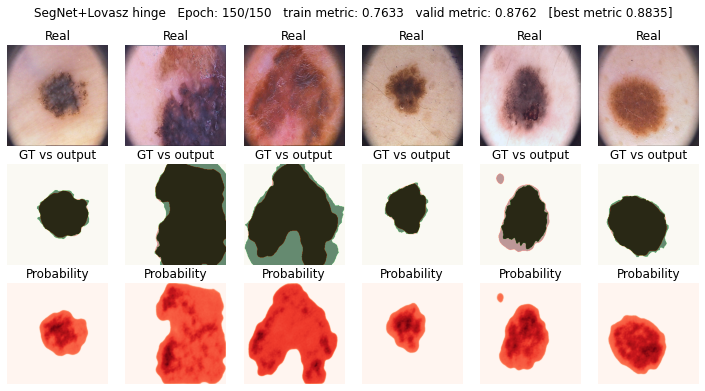

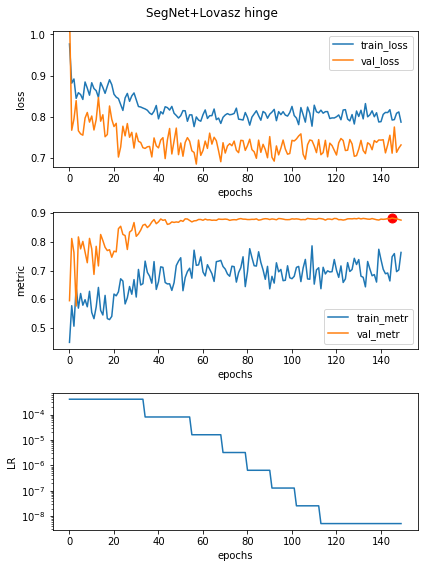

Weights loaded from best epoch 146, metric = 0.8835


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4   SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07

In [52]:
clear_GPU()
model = SegNet().to(device)
loss = lovasz_hinge
name = 'SegNet+Lovasz hinge'

max_epochs = pretrain_cycle
base_lr = 5e-3
optim = torch.optim.AdamW([
    dict(params=model.dec_conv0.parameters()),
    dict(params=model.dec_conv1.parameters()),
    dict(params=model.dec_conv2.parameters()),
    dict(params=model.dec_conv3.parameters()),
    dict(params=model.dec_conv4.parameters()),
], lr=base_lr, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

max_epochs = full_epoch_cycle
base_lr = 4e-4 # 2e-4
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, 
                               data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

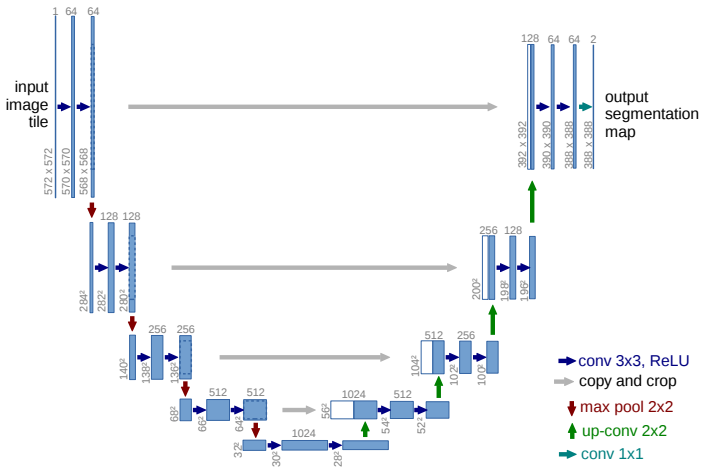

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [53]:
def convolution_block(in_channels=512, out_channels=256, drop=0.2):
    conv_params = dict(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    bn_params = dict()#momentum=0.9
    res = torch.nn.Sequential()
    res.add_module('conv1', nn.Conv2d(in_channels, out_channels, **conv_params))
    res.add_module('bn1', nn.BatchNorm2d(out_channels, **bn_params))
    res.add_module('do1', nn.Dropout2d(drop))
    res.add_module('relu1', nn.ReLU(inplace=True))
    res.add_module('conv2', nn.Conv2d(out_channels, out_channels, **conv_params))
    res.add_module('bn2', nn.BatchNorm2d(out_channels, **bn_params))
    res.add_module('do2', nn.Dropout2d(drop))
    res.add_module('relu2', nn.ReLU(inplace=True))
    return res

Будем делать упрощенный U-net, где на каждом слое добавлен паддинг, чтобы размер картинок в энкодере и декодере был одинаковым.

In [54]:
class UNet(nn.Module):
    def __init__(self, drop_down=0.2, drop_up=0.2):
        pool_params = dict(kernel_size=2, stride=2) #, padding=None)
        upsample_params = dict(scale_factor=2, mode='nearest')
        super().__init__()

        # encoder (downsampling)
        self.pool = nn.MaxPool2d(**pool_params)
        self.upsample = nn.Upsample(**upsample_params)
        
        self.enc_conv0 = convolution_block(3, 64, drop_down)
        self.enc_conv1 = convolution_block(64, 128, drop_down)
        self.enc_conv2 = convolution_block(128, 256, drop_down)
        self.enc_conv3 = convolution_block(256, 512, drop_down)

        # bottleneck
        self.bottleneck_conv = convolution_block(512, 1024, drop_down)

        # decoder (upsampling)
        self.dec_conv0_up = nn.Conv2d(1024, 512, 3, padding=1)
        self.dec_conv0 = convolution_block(1024, 512, drop_up)
        self.dec_conv1_up = nn.Conv2d(512, 256, 3, padding=1)
        self.dec_conv1 = convolution_block(512, 256, drop_up)
        self.dec_conv2_up = nn.Conv2d(256, 128, 3, padding=1)
        self.dec_conv2 = convolution_block(256, 128, drop_up)
        self.dec_conv3_up = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_conv3 = convolution_block(128, 64, drop_up)
        
        self.out_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1)
    

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 64 x 256 x 256
        e1 = self.enc_conv1(self.pool(e0)) # 128 x 128 x 128
        e2 = self.enc_conv2(self.pool(e1)) # 256 x 64 x 64
        e3 = self.enc_conv3(self.pool(e2)) # 512 x 32 x 32

        # bottleneck
        b = self.bottleneck_conv(self.pool(e3)) # 1024 x 16 x 16

        # decoder
        d0 = self.upsample(b) # 1025 x 32 x 32
        d0 = self.dec_conv0_up(d0) # 512 x 32 x 32
        d0 = torch.cat([d0, e3], dim=1) # 1024 x 32 x 32
        d0 = self.dec_conv0(d0) # 512 x 32 x 32
        
        d1 = self.upsample(d0) # 512 x 64 x 64
        d1 = self.dec_conv1_up(d1) # 256 x 64 x 64
        d1 = torch.cat([d1, e2], dim=1) # 512 x 64 x 64
        d1 = self.dec_conv1(d1) # 256 x 64 x 64
        
        d2 = self.upsample(d1)
        d2 = self.dec_conv2_up(d2)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)
        
        d3 = self.upsample(d2)
        d3 = self.dec_conv3_up(d3)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)

        return self.out_conv(d3)

In [55]:
model = UNet()
x_test = torch.randn((2,3,256,256))
model(x_test).shape

torch.Size([2, 1, 256, 256])

## Обучение

Прогоним обучение со всеми функциями потерь.

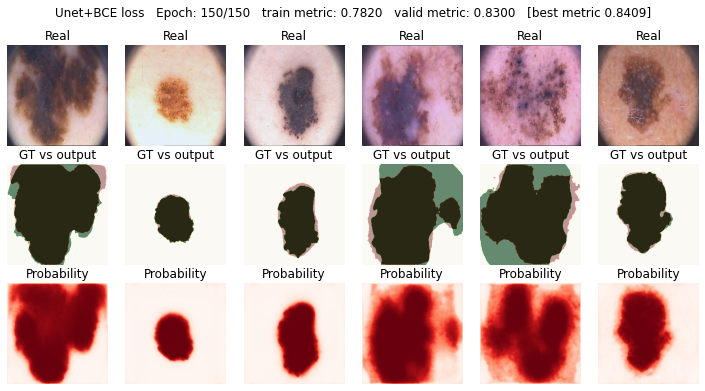

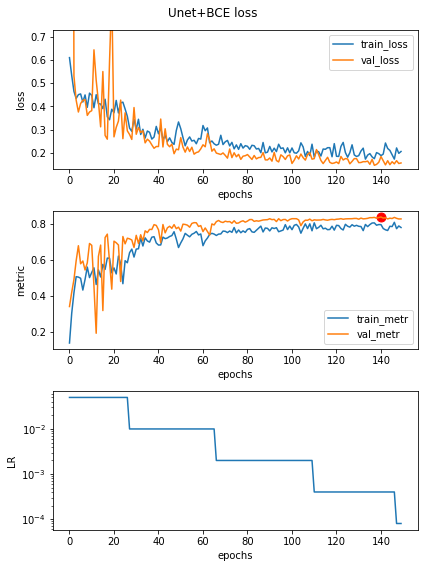

Weights loaded from best epoch 141, metric = 0.8409


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4   SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5         Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07

In [56]:
clear_GPU
model = UNet().to(device)
name = 'Unet+BCE loss'
loss = bce_loss_stable

max_epochs = full_epoch_cycle
base_lr = 5e-2
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=8)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

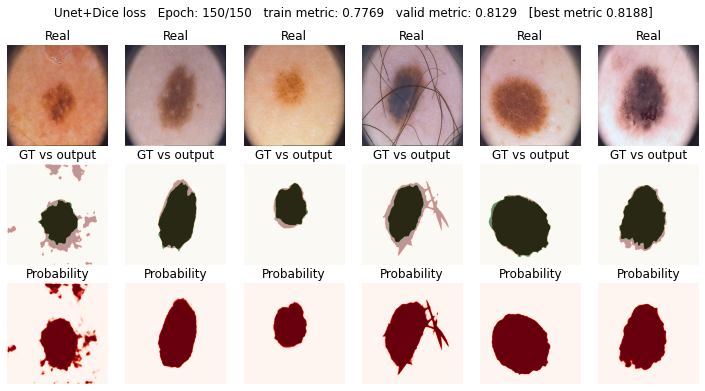

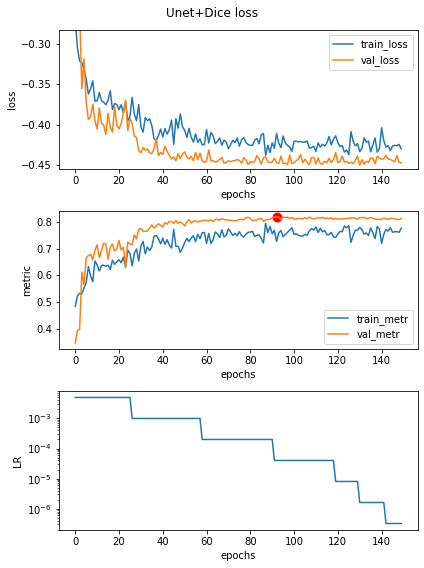

Weights loaded from best epoch 93, metric = 0.8188


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4   SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5         Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6        Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07

In [57]:
clear_GPU
model = UNet().to(device)
name = 'Unet+Dice loss'
loss = dice_loss

max_epochs = full_epoch_cycle
base_lr = 5e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

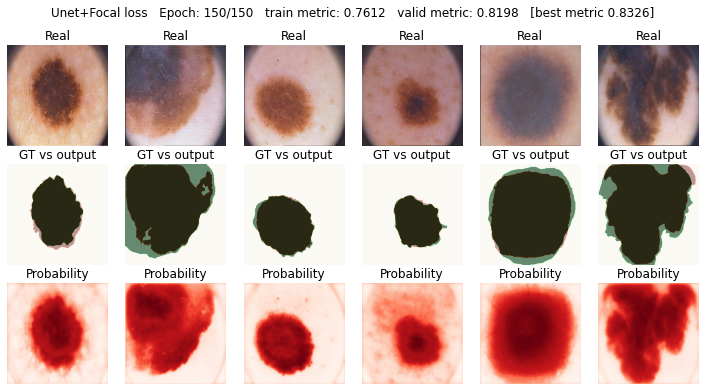

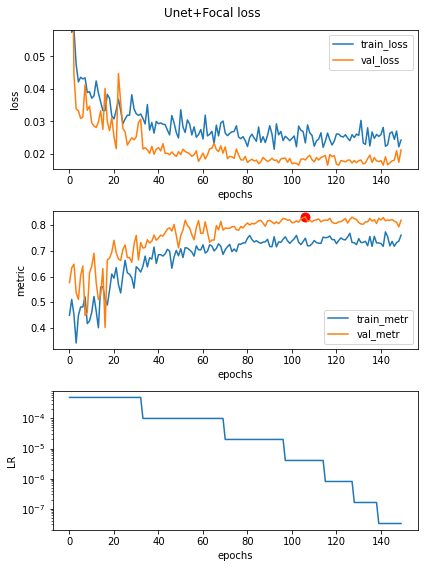

Weights loaded from best epoch 107, metric = 0.8326


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4   SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5         Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6        Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7       Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07

In [58]:
clear_GPU
model = UNet().to(device)
name = 'Unet+Focal loss'
loss = focal_loss

max_epochs = full_epoch_cycle
base_lr = 5e-4
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

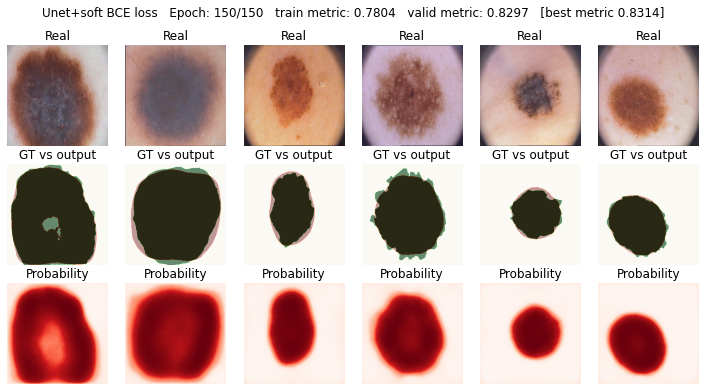

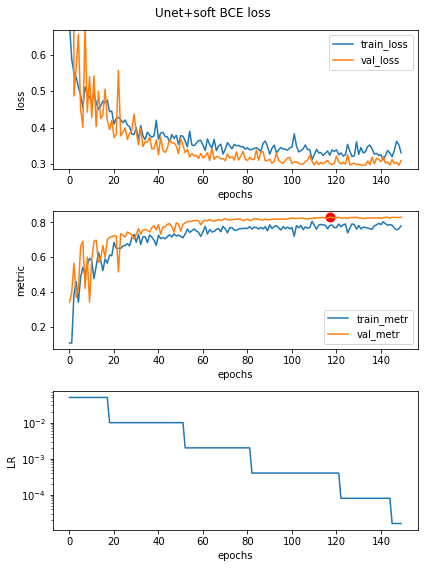

Weights loaded from best epoch 118, metric = 0.8314


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4   SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5         Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6        Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7       Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8    Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07

In [59]:
clear_GPU
model = UNet().to(device)
name = 'Unet+soft BCE loss'
loss = soft_target_bce_loss

max_epochs = full_epoch_cycle
base_lr = 5e-2
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

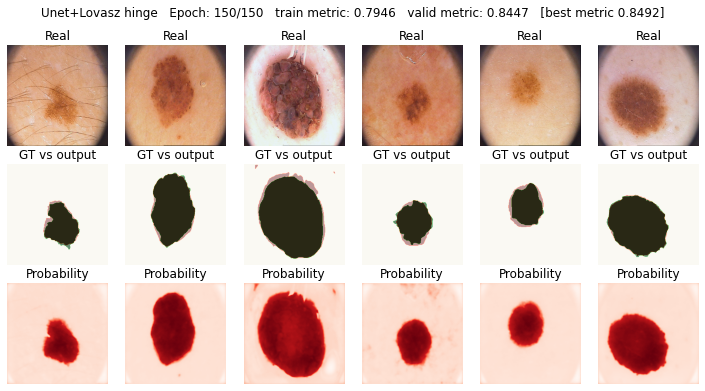

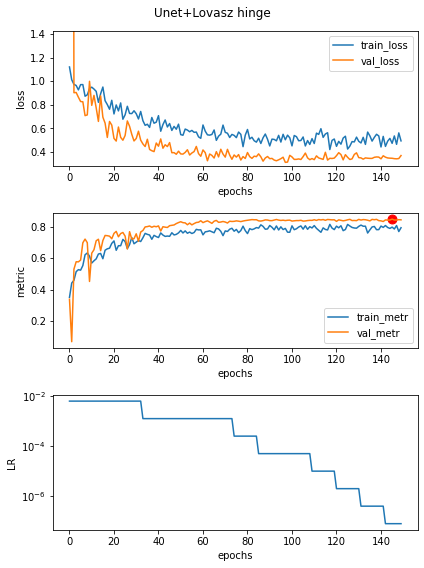

Weights loaded from best epoch 146, metric = 0.8492


name  train_metr  val_metr  test_metr   params
0       SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1      SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2     SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3  SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4   SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5         Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6        Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7       Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8    Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
9     Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07

In [60]:
clear_GPU
model = UNet().to(device)
name = 'Unet+Lovasz hinge'
loss = lovasz_hinge

max_epochs = full_epoch_cycle
base_lr = 6e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

# Unet-2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

In [61]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = convolution_block(3, 64)
        self.enc_conv0_down = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.enc_conv1 = convolution_block(64, 128)
        self.enc_conv1_down = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        self.enc_conv2 = convolution_block(128, 256)
        self.enc_conv2_down = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        self.enc_conv3 = convolution_block(256, 512)
        self.enc_conv3_down = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = convolution_block(512, 1024)

        # decoder (upsampling)
        conv_trans_params = dict(kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv0_up = nn.ConvTranspose2d(1024, 512, **conv_trans_params)
        self.dec_conv0 = convolution_block(1024, 512)
        self.dec_conv1_up = nn.ConvTranspose2d(512, 256, **conv_trans_params)
        self.dec_conv1 = convolution_block(512, 256)
        self.dec_conv2_up = nn.ConvTranspose2d(256, 128, **conv_trans_params)
        self.dec_conv2 = convolution_block(256, 128)
        self.dec_conv3_up = nn.ConvTranspose2d(128, 64, **conv_trans_params)
        self.dec_conv3 = convolution_block(128, 64)
        
        self.out_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.enc_conv0_down(e0))
        e2 = self.enc_conv2(self.enc_conv1_down(e1))
        e3 = self.enc_conv3(self.enc_conv2_down(e2))

        # bottleneck
        b = self.bottleneck_conv(self.enc_conv3_down(e3))

        # decoder
        d0 = self.dec_conv0_up(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.dec_conv1_up(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)
        
        d2 = self.dec_conv2_up(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)
        
        d3 = self.dec_conv3_up(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)

        return self.out_conv(d3)

In [62]:
model = UNet2()
x_test = torch.randn((2,3,256,256))
model(x_test).shape

torch.Size([2, 1, 256, 256])

## Обучение

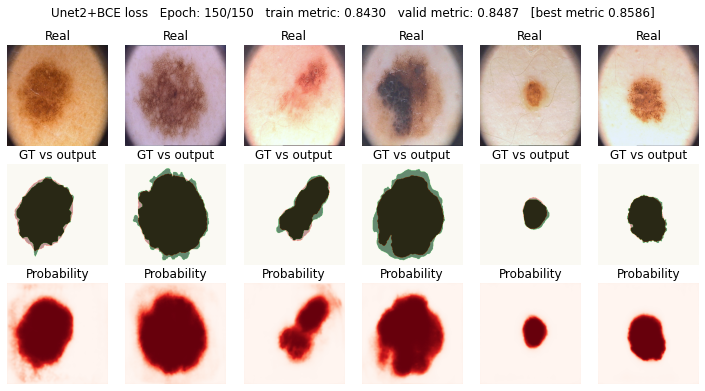

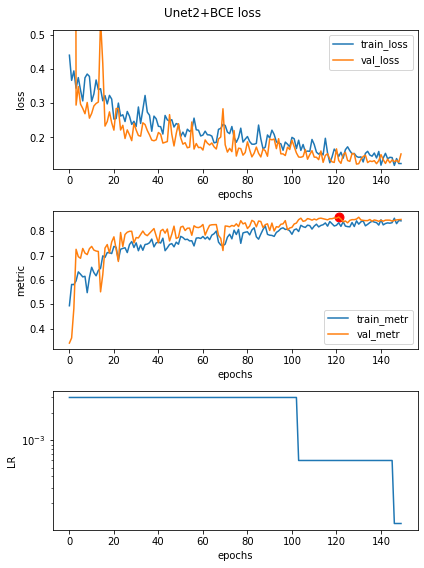

Weights loaded from best epoch 122, metric = 0.8586


name  train_metr  val_metr  test_metr   params
0        SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1       SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2      SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3   SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4    SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5          Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6         Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7        Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8     Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
9      Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07
10        Unet2+BCE loss    0.856506  0.858613   0.865972  3.6e+07

In [63]:
clear_GPU
model = UNet2().to(device)
name = 'Unet2+BCE loss'
loss = bce_loss_stable

max_epochs = full_epoch_cycle
base_lr = 3e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=15)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

result = get_all_scores(model, name, result)

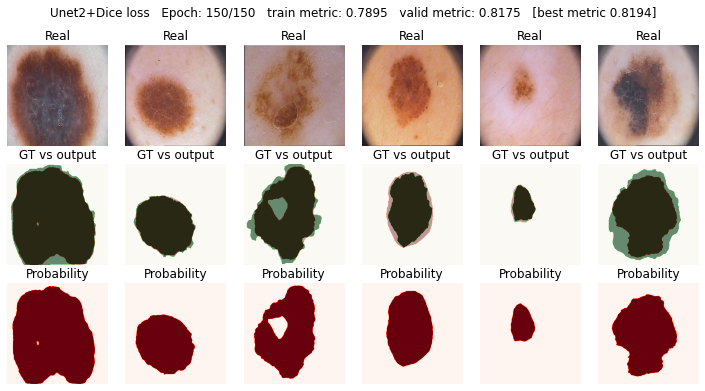

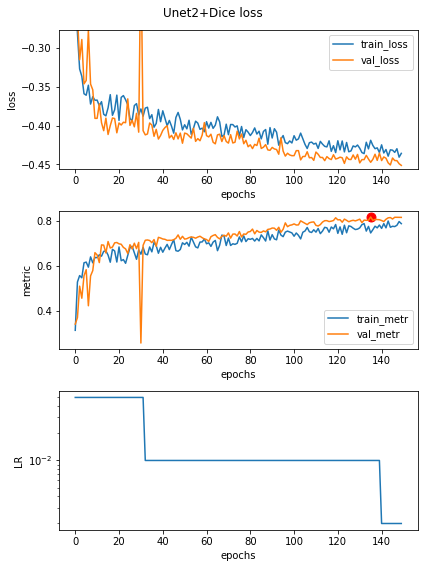

Weights loaded from best epoch 136, metric = 0.8194


name  train_metr  val_metr  test_metr   params
0        SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1       SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2      SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3   SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4    SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5          Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6         Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7        Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8     Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
9      Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07
10        Unet2+BCE loss    0.856506  0.858613   0.865972  3.6e+07
11       Unet2+Dice loss    0.810374  0.819376   0.825366  3.6e+07

In [64]:
clear_GPU
model = UNet2().to(device)
name = 'Unet2+Dice loss'
loss = dice_loss

max_epochs = full_epoch_cycle
base_lr = 5e-2
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=15)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

result = get_all_scores(model, name, result)

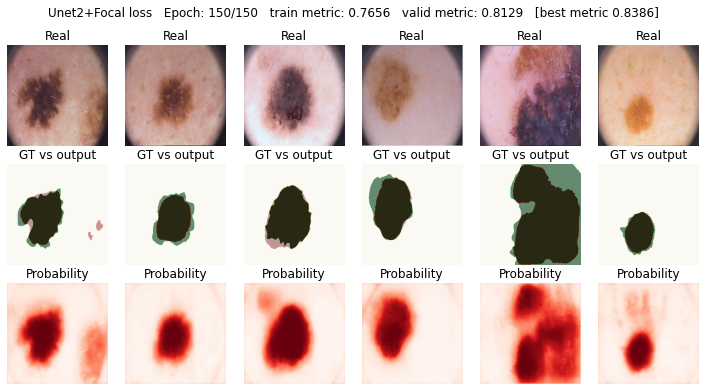

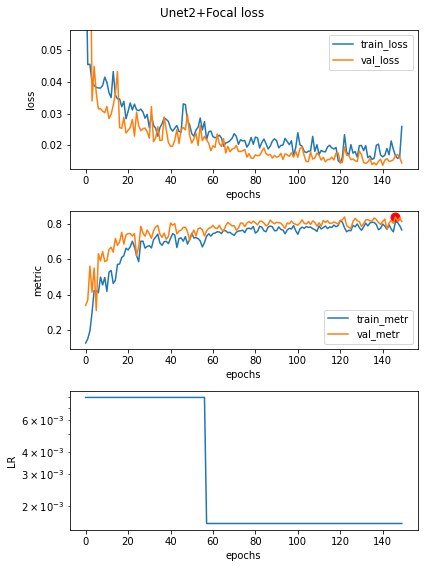

Weights loaded from best epoch 147, metric = 0.8386


name  train_metr  val_metr  test_metr   params
0        SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1       SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2      SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3   SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4    SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5          Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6         Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7        Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8     Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
9      Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07
10        Unet2+BCE loss    0.856506  0.858613   0.865972  3.6e+07
11       Unet2+Dice loss    0.810374  0.819376   0.825366  3.6e+07
12      Unet2+Focal loss    0.845827  0.838589   0.857133  3.6e+07

In [65]:
clear_GPU
model = UNet2().to(device)
name = 'Unet2+Focal loss'
loss = focal_loss

max_epochs = full_epoch_cycle
base_lr = 8e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=15)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

result = get_all_scores(model, name, result)

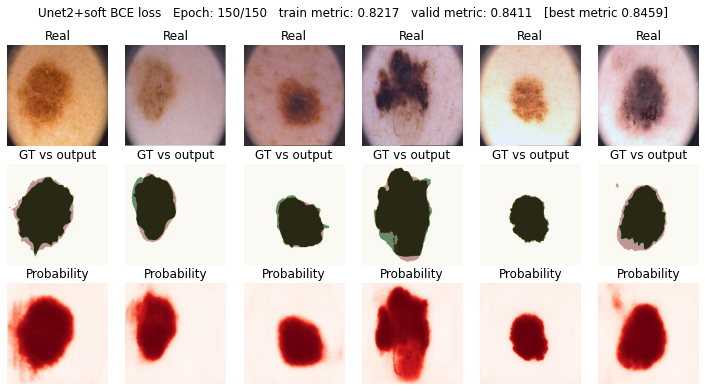

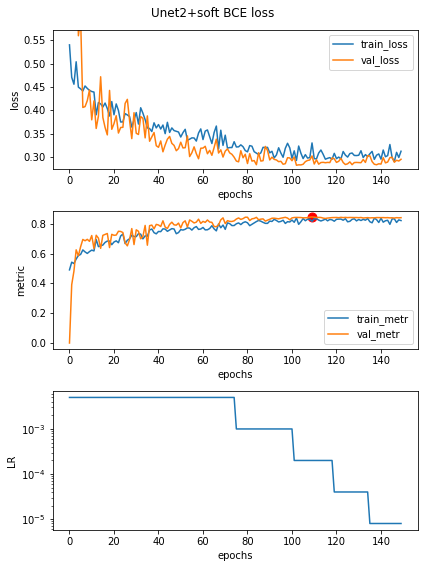

Weights loaded from best epoch 110, metric = 0.8459


name  train_metr  val_metr  test_metr   params
0        SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1       SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2      SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3   SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4    SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5          Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6         Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7        Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8     Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
9      Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07
10        Unet2+BCE loss    0.856506  0.858613   0.865972  3.6e+07
11       Unet2+Dice loss    0.810374  0.819376   0.825366  3.6e+07
12      Unet2+Focal loss    0.845827  0.838589   0.857133  3.6e+07
13   Unet2+soft BCE loss    0.850435  0.845871   0.856583  3.6e+07

In [66]:
clear_GPU
model = UNet2().to(device)
name = 'Unet2+soft BCE loss'
loss = soft_target_bce_loss

max_epochs = full_epoch_cycle
base_lr = 5e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=15)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name);

result = get_all_scores(model, name, result)

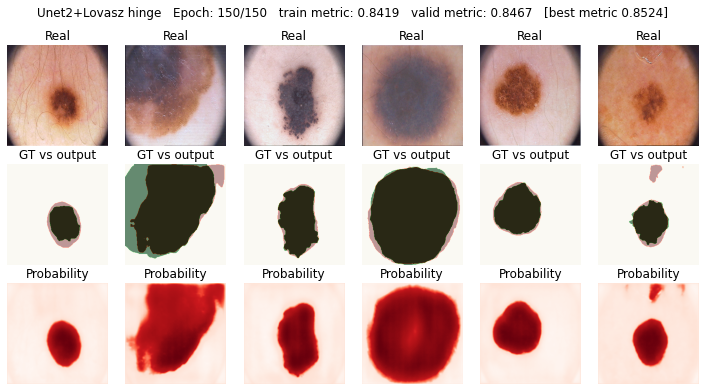

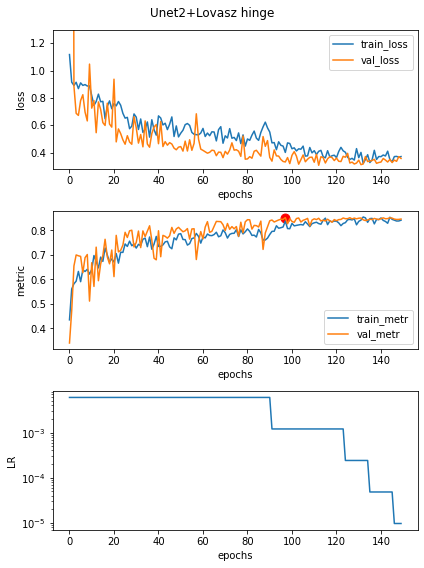

Weights loaded from best epoch 98, metric = 0.8524


name  train_metr  val_metr  test_metr   params
0        SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1       SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
2      SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
3   SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
4    SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
5          Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
6         Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7        Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07
8     Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
9      Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07
10        Unet2+BCE loss    0.856506  0.858613   0.865972  3.6e+07
11       Unet2+Dice loss    0.810374  0.819376   0.825366  3.6e+07
12      Unet2+Focal loss    0.845827  0.838589   0.857133  3.6e+07
13   Unet2+soft BCE loss    0.850435  0.845871   0.856583  3.6e+07
14    Unet2+Lovasz hinge    0.830598  0.852429   0.861564  3.6e+07

In [67]:
clear_GPU
model = UNet2().to(device)
name = 'Unet2+Lovasz hinge'
loss = lovasz_hinge

max_epochs = full_epoch_cycle
base_lr = 6e-3
optim = torch.optim.AdamW(params=model.parameters(), lr=base_lr, weight_decay=1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=factor, patience=10)
complete_history[name] = train(model, optim, loss, max_epochs, data_tr, data_val, iou_numpy, scheduler, name=name)

result = get_all_scores(model, name, result)

Сделайте вывод, какая из моделей лучше

# Задание - отчет:
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Отчет

## Выполненные работы

### Аугментация данных

Обучающий датасет при обучении был аугментирован случайным образом, включая:
- случайные отражения (вертикальное и горизонтальное)
- цветовой сдвиг
- изменения контраста и яркости

Повороты не применялись, так как это создавало дефекты на краях изображения, что приводило к нестабильности обучения.

### Реализованные архитектуры сетей

В ходе работы были реализованы три архитектурые CNN для задач сегментации:
- на основе SegNet. Энкодер - предобученный без изменений от vgg16_bn (с батч-нормализацией). Декодер - симметричный с БН и дропаутом после БН. Отличие от статьи - разрешения изображений (не принципиально)
- на основе Unet. Все свертки с БН и дропаутом. Важное отличие от статьи - в каждом сверточном слое используется паддинг 1, что позволяет получить на выходе такой же размер изображения, что и на входе, хотя, вероятно, снижает точность модели на границе изображения
- на основе Unet с модифицированным способом умеьшения/увеличения изображения. Макспулинг заменен на свертку со страйдом 2, апсэмплинг заменен на transpose-convolutions со страйдом 2. В остальном то же самое

В качестве метрики использовалась IOU (или Jaccard index)

### Реализованные функции потерь

Были написаны и использованы 5 функций потерь:
- бинарная кросс-энтропия ([в численно стабилизированном варианте](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits))
- Dice coefficient, приближающая метрику IOU дифференцируемым образом
- Focal loss, снижающая вес хорошо классифицируемых объектов. [Статья](https://arxiv.org/pdf/1708.02002.pdf), сама [формула](https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.binary_focal_loss.html#focal_loss.binary_focal_loss) в одном из вариантов
- Soft target BCE. В ней метки классов сглаживаются так, чтобы модель получала штраф за сверхуверенность
- Lovasz Hinge. Более сложный вариант hinge loss, где ошибки по объектам сначала сортируются, а затем на основе этой сортировки вычисляются их веса и градиенты от них. [Пояснения](https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/67791)

## Методика эксперимента

Каждая из моделей была обучена с использованием всех функций потерь. Везде использовался оптимизатор adamW. LR подбирался индивидуально вручную. Для каждой функции потерь рабочий диапазон LR оказался своим. При задании LR вне диапазона сходимость не достигалась.

Модели на основе SegNet с предобученным энкодером от VGG16 обучались в два этапа. На первом этапе обучался только декодер, чтобы согласовать его с энкодером. Затем все веса размораживались и модель обучалась целиком.

Таким образом, были обучены 15 моделей. В результате обучения использовались те веса моделей, при которых метрика была максимальна на валидационной выборке. После обучения были измерены метрики IOU всех моделей на всех выборках.

## Результаты эксперимента

### Метрики качества

Ниже представлена таблица, в которой метрика на тестовой выборке сортирована по убыванию (выше - лучше).

In [79]:
result.to_csv('skin_segment_result.csv')
result.sort_values('test_metr', ascending=False)

name  train_metr  val_metr  test_metr   params
0        SegNet+BCE loss    0.911104  0.897901   0.892924  3.0e+07
1       SegNet+Dice loss    0.865616  0.881788   0.881488  3.0e+07
4    SegNet+Lovasz hinge    0.889656  0.883540   0.872880  3.0e+07
3   SegNet+soft BCE loss    0.847843  0.843842   0.865979  3.0e+07
10        Unet2+BCE loss    0.856506  0.858613   0.865972  3.6e+07
9      Unet+Lovasz hinge    0.844631  0.849205   0.862717  3.5e+07
14    Unet2+Lovasz hinge    0.830598  0.852429   0.861564  3.6e+07
12      Unet2+Focal loss    0.845827  0.838589   0.857133  3.6e+07
13   Unet2+soft BCE loss    0.850435  0.845871   0.856583  3.6e+07
5          Unet+BCE loss    0.830374  0.840868   0.850255  3.5e+07
8     Unet+soft BCE loss    0.809266  0.831364   0.842162  3.5e+07
2      SegNet+Focal loss    0.838233  0.841478   0.841014  3.0e+07
11       Unet2+Dice loss    0.810374  0.819376   0.825366  3.6e+07
6         Unet+Dice loss    0.778613  0.818760   0.823403  3.5e+07
7        Unet+Focal loss    0.785333  0.832557   0.821156  3.5e+07

Видим, что лучший результат показала сеть на основе SegNet. Объяснить это можно тем, что в нашем датасете нет необходимости сегментировать тонкие линии и другие мелкие элементы. Таким образом, Unet не получает преимущества от своей архитектуры. В то же время, Unet имеет больше весов и более склонна к переобучению.

Отметим, что все пять используемых функций потерь привели к сходимости.

Ниже приведены графики зависимостей метрики IOU от эпохи обучения. Отмечены точки достижения максимальной метрики.

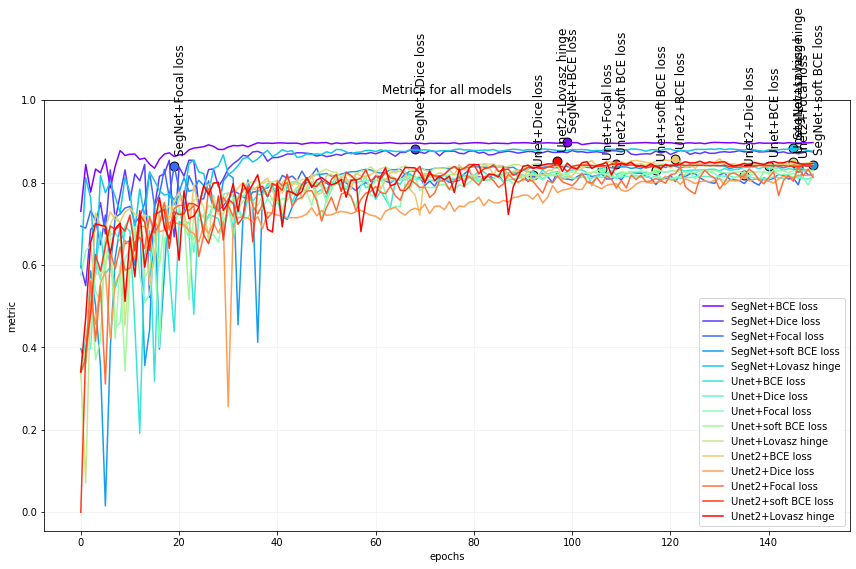

In [76]:
colors=cm.rainbow(np.linspace(0, 1, len(list(complete_history.keys()))))
fig = plt.figure(figsize=(12, 8))
for k, c in zip(list(complete_history.keys()), colors):
    val_metr = complete_history[k]['val_metr']
    plt.plot(val_metr, label=k, c=c)
    # my = np.array(val_metr).max()
    # mx = np.argmax(np.array(val_metr))
    # plt.scatter(x=[mx], y=[my], color=c, s=80, linewidth=1, edgecolor='black')
    # plt.text(mx, my+0.03, k, fontsize = 12, rotation=90)
    
for k, c in zip(list(complete_history.keys()), colors):
    val_metr = complete_history[k]['val_metr']
    # plt.plot(val_metr, label=k, c=c)
    my = np.array(val_metr).max()
    mx = np.argmax(np.array(val_metr))
    plt.scatter(x=[mx], y=[my], color=c, s=120, linewidth=1, edgecolor='black')
    plt.text(mx, my+0.03, k, fontsize = 12, rotation=90)
    
plt.legend()
plt.xlabel("epochs")
plt.ylabel("metric")
plt.title('Metrics for all models')
fig.patch.set_facecolor('xkcd:white')
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.ylim(top=1)
fig.tight_layout()
plt.show()

Видим, что ряд SegNet моделей (оттенки синего) явно группируется сверху и обладает более высоким качеством.

В то же время, можно сказать, что все модели обучились и "адекватно" воспринимают мир.

### Достижение сходимости

Посмотрим отдельно на кривые обучения (лосса на валидации) для каждого типа лоссов.

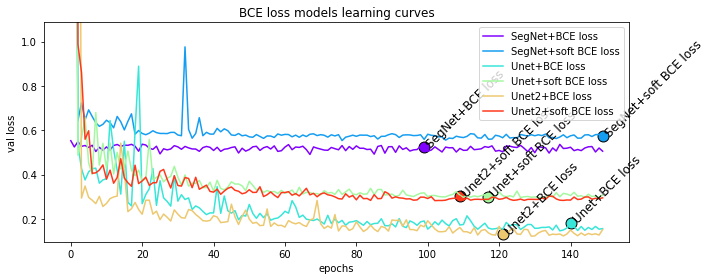

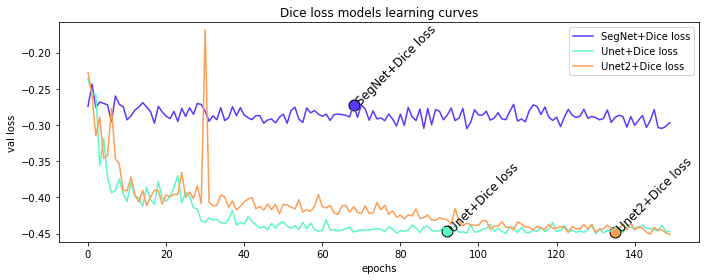

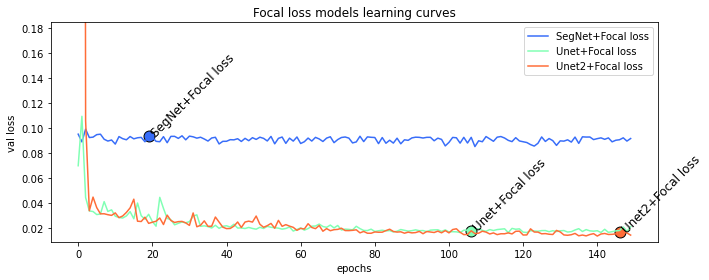

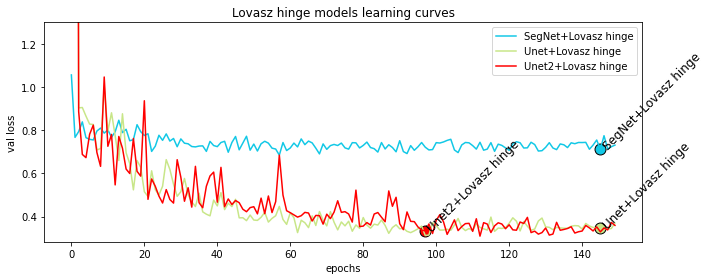

In [90]:
for loss_name in ['BCE loss', 'Dice loss', 'Focal loss', 'Lovasz hinge']:
    fig = plt.figure(figsize=(10, 4))
    points = np.array([])
    for k, c in zip(list(complete_history.keys()), colors):
        if loss_name not in k: continue
        val_loss = complete_history[k]['val_loss']
        val_metr = complete_history[k]['val_metr']
        points = np.append(points, val_loss).astype(float)
        
        plt.plot(val_loss, label=k, c=c)
        mx = np.argmax(np.array(val_metr))
        my = val_loss[mx]
        plt.scatter(x=[mx], y=[my], color=c, s=120, linewidth=1, edgecolor='black')
        plt.text(mx, my, k, fontsize = 12, rotation=45)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    plt.ylim(lim1, lim2)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("val loss")
    plt.title(loss_name + ' models learning curves')
    fig.patch.set_facecolor('xkcd:white')
    fig.tight_layout()
    plt.show()

Кривые показывают, что все модели обучены до сходимости. Кроме того, интересно, что часто лучшая метрика (круги) достигается не на минимальном лоссе. Это обусловлено тем, что требования минимизации лосса и максимизации метрики не являются математически идентичными.

### Переобучение

Посмотрим на кривые лосса на обучении и валидации, чтобы понять, не переобучились ли наши модели.

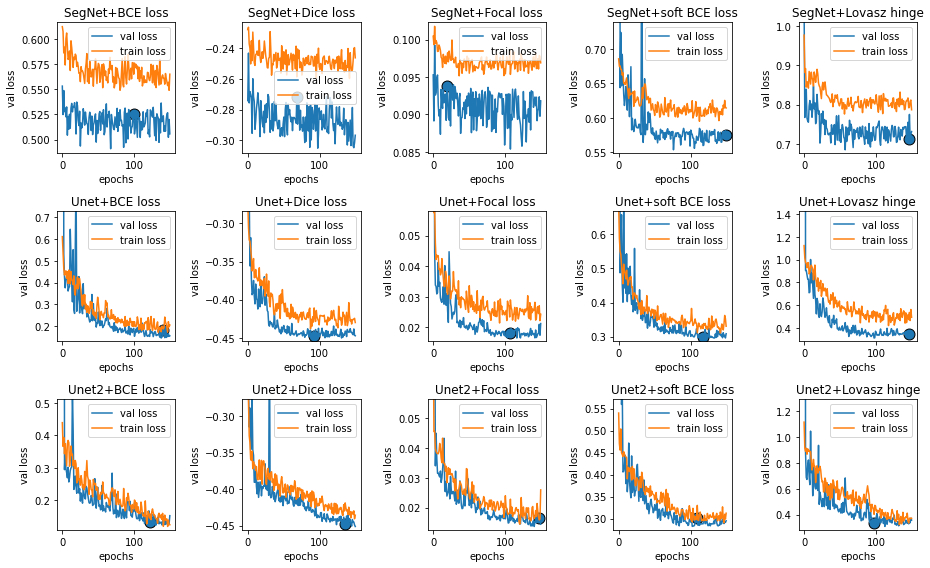

In [88]:
fig = plt.figure(figsize=(13, 8))
for i, (k, c) in enumerate(zip(list(complete_history.keys()), colors)):
    plt.subplot(3,5,i+1)
    val_loss = complete_history[k]['val_loss']
    train_loss = complete_history[k]['train_loss']
    val_metr = complete_history[k]['val_metr']
    points = np.array(val_loss + train_loss).astype(float)
    points = points[~np.isnan(points)]
    points = points[np.isfinite(points)]
    plt.plot(val_loss, label='val loss')
    plt.plot(train_loss, label='train loss')
    mx = np.argmax(np.array(val_metr))
    my = val_loss[mx]
    plt.scatter(x=[mx], y=[my], s=120, linewidth=1, edgecolor='black')
    p = 0.08
    q1, q2 = np.nanquantile(points, p), np.nanquantile(points, 1-p)
    iqr = q2 - q1
    lim1 = max(np.nanmin(points) - iqr * 0.06, q1 - iqr * 1.2)
    lim2 = min(np.nanmax(points) + iqr * 0.06, q2 + iqr * 1.2)
    plt.ylim(lim1, lim2)
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("val loss")
    plt.title(k)
    
fig.patch.set_facecolor('xkcd:white')
fig.tight_layout()
plt.show()

Видим, что все модели не переобучены, то есть лосс на тренировке на каждой модели в среднем выше, чем на валидации.

## Выводы

Для сегментации изображения без мелких/тонких деталей вполне подходит SegNet, Unet при этом теряет своей преимущество.

Все модели не переобучены, более того, для некоторых разрыв между лоссом на обучении и валидации говорит, что, вероятно, степень регуляризации модели была слишком сильной и модель, скорее, недообучилась.

В моделях использована батч-нормализация. Возможно, при малом размере батча ее лучше было бы отключить.

Из всех функций потерь наиболее стабильное обучение обеспечивают классическая BCE и BCE с soft labels, хотя лучший результат достигнут именно на классической BCE.

Стабильность обучения очень сильно зависит от выбранного LR. Выбор выполнен вручную, оптимальность выбора не доказана, но все выбранные LR работоспособны.

Везде использовался оптимзатор adamW. Возможно, обучение выиграло бы от использования какого-либо другого оптимизатора, основанного на momentum с более понятным его контроем, так как при обучении были использованы малые батчи (размер 8), поэтому momentum очень важен для сохранения адекватного "общего направления" обучения.

Таким образом, все запланированные работы были выполнены. Срок выполнения составил 8 дней, финальный расчет - около 8 часов.